# Dynamically Adaptable Virtual Machines for Sustainable Websites

This notebook aim at providing the analysis process of our paper

## Imports

In [ ]:
import json 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
from math import sqrt
import scipy.stats as stats

## Website Carbon

This script aim to provide the energy consumption and carbon impact of website requests.

### Constants

In [ ]:
# Path to the folder containing HAR files
HAR_FOLDER = "./Data_Transfer/"

# Algorithm constants
KWG_PER_GB = 1.805
KWH_PER_BYTE = KWG_PER_GB / 1073741824
RETURNING_VISITOR_PERCENTAGE = 0.75
FIRST_TIME_VIEWING_PERCENTAGE = 0.25
PERCENTAGE_OF_DATA_LOADED_ON_SUBSEQUENT_LOAD = 0.02
CARBON_PER_KWG_GRID = 475
CARBON_PER_KWG_RENEWABLE = 33.4
PERCENTAGE_OF_ENERGY_IN_DATACENTER = 0.1008
PERCENTAGE_OF_ENERGY_IN_TRANSMISSION_AND_END_USER = 0.8992
CO2_GRAMS_TO_LITRES = 0.5562

# Data access constants
NORMAL = 0
ADAPTED = 1

### Functions

adjustDataTranfert : calculate the average transfert size considering caching capacity of web browser

energyConsumption : calculate the energy consumption from the tranfert size

getCo2Grid : calculate the equivalent CO2 when using a classic host

getCo2Renewable : calculate the equivalent CO2 when using a green host

co2ToLitres : convert CO2 mass to volume

getStatistics : aggregate previous statistics

cleanerThan : compare to other sites

In [ ]:
def adjustDataTransfer(val): 
    out =  val * RETURNING_VISITOR_PERCENTAGE 
    out += val * PERCENTAGE_OF_DATA_LOADED_ON_SUBSEQUENT_LOAD * FIRST_TIME_VIEWING_PERCENTAGE
    return out

In [ ]:
def energyConsumption(bytes): 
    return bytes * KWH_PER_BYTE;

In [ ]:
def getCo2Grid(energy):
    return energy * CARBON_PER_KWG_GRID;

In [ ]:
def getCo2Renewable(energy):
    out =  energy * PERCENTAGE_OF_ENERGY_IN_DATACENTER * CARBON_PER_KWG_RENEWABLE
    out += energy * PERCENTAGE_OF_ENERGY_IN_TRANSMISSION_AND_END_USER * CARBON_PER_KWG_GRID
    return out

In [ ]:
def co2ToLitres(co2):
    return co2 * CO2_GRAMS_TO_LITRES;

In [ ]:
def getStatistics(bytes):
    bytesAdjusted = adjustDataTransfer(bytes);
    energy = energyConsumption(bytesAdjusted);
    co2Grid = getCo2Grid(energy);
    co2Renewable = getCo2Renewable(energy);

    return {
        'adjustedBytes' : bytesAdjusted,
        'energy' : energy,
        'co2' : {
            'grid' : {
                'grams' : co2Grid,
                'litres': co2ToLitres(co2Grid)
            },
            'renewable' : {
                'grams' : co2Renewable,
                'litres' : co2ToLitres(co2Renewable)
            }
        }
    }

In [ ]:
def cleanerThan(co2):
    # This array needs to be updated periodically with new data. This was
    # originally calculated with a database query but that was too slow at
    # scale. We can look in to writing a cron job that will generate and export
    # from the database once a month, that is then loaded in this file.

    # This array was last generated with rankings/index.php on 27/01/2020
    percentiles = [0.00126957622871866,0.004035396817140881,0.012595561048805604,0.023304715095553624,0.036438786824583,0.050362397616329,0.064014899640461,0.077739052678226,0.092126836186624,0.10757047217165,0.125027739890344,0.140696302455872,0.15929047315768,0.177734818869488,0.19581439489964,0.21422507361825607,0.232736823359142,0.246082174332492,0.264348156430992,0.28306902111392,0.30180466482882,0.320295382181204,0.33950686554985604,0.360111566931774,0.38114308483189,0.40185357017186396,0.42035354145420606,0.4393550630164101,0.458541453493762,0.47918906703882,0.499654077413412,0.521285635156174,0.5405494875603221,0.56161428648152,0.58238456980151,0.604316363860106,0.6256429617179278,0.6478269528228661,0.6691073942929641,0.68867154881184,0.7103787320465419,0.7331362414675519,0.7562483364936439,0.780892842691506,0.80396830015467,0.8269877794821401,0.85060546199698,0.874387816802448,0.899691291111552,0.92324242726303,0.9511826145960923,0.976586133398462,1.002258239346,1.02822903453074,1.0566669431626,1.08448123862022,1.1130571798008,1.1446436812039398,1.17548103245766,1.2075157831423,1.2419762271574795,1.27780212823068,1.31343697309996,1.3535322129548801,1.3963404885134,1.43538821676594,1.4786819721653202,1.52287253339568,1.5710404823845998,1.6176354301871,1.6627899659050596,1.71503331661196,1.7731704594157403,1.8271314036959998,1.8888232850004,1.9514501162933802,2.01843049142384,2.08929918752446,2.1680425684300615,2.2538809089543,2.347435716407921,2.44446281762258,2.551568006854039,2.6716183180923796,2.8030676779506,2.947526052684458,3.1029734241542397,3.2801577012624605,3.4659335564053406,3.6858566410374,3.9539822299055203,4.2833358140900835,4.686514950833381,5.167897618200399,5.7413021838327,6.52500051792535,7.628926245040858,9.114465674521588,12.30185529895519,92.584834950345]

    for i in range(0, 100):
        value = percentiles[i]
        if(co2 < value):
            return (100 - i)
    return 0

In [ ]:
def printInfo(bytesNb):
  stats = getStatistics(bytesNb)
  energy = stats["energy"]
  grams = stats["co2"]["grid"]["grams"]
  greenerThan = cleanerThan(grams)
  if(greenerThan > 50):
      print("\033[1;32;48mThis page is cleaner than " + str(greenerThan) + "% of web pages tested\033[00m")
  else:
      print("\033[1;31;48mThis page is dirtier than " + str(99-greenerThan) + "% of web pages tested\033[00m")
  print("\033[01m"+str(round(grams,3)) + "g of CO2\033[00m is produced every time someone visits this web page ("+str(round(energy,4))+" KWH)")

### Data

Build the datastructure from the HAR files

In [ ]:
HAR_FILES = glob.glob(HAR_FOLDER+"*.har")

data = []

for HAR_FILE in HAR_FILES:
    normal = open(HAR_FILE, "r")
    adapted = open(HAR_FILE+".adapted", "r")
    if normal.mode == 'r' and adapted.mode == 'r':
        contents = normal.read()
        jsonObj = json.loads(contents)
        normal_bytes = 0
        for r in jsonObj["log"]["entries"]:
            normal_bytes += r["response"]["bodySize"]

        contents = adapted.read()
        jsonObj = json.loads(contents)
        adapted_bytes = 0
        for r in jsonObj["log"]["entries"]:
            adapted_bytes += r["response"]["bodySize"]
      
        entry = {
            "name": HAR_FILE, 
            "transferSizes" : [normal_bytes, adapted_bytes]
        }
        data.append(entry)
      

[{'name': './Data_Transfer/y2mate.har', 'transferSizes': [135695, 196390]},
 {'name': './Data_Transfer/genius.har', 'transferSizes': [1712809, 127458]},
 {'name': './Data_Transfer/britannica.har',
  'transferSizes': [1198040, 212265]},
 {'name': './Data_Transfer/spanishdict.har',
  'transferSizes': [475137, 166556]},
 {'name': './Data_Transfer/dailymail.har', 'transferSizes': [6342091, 367507]},
 {'name': './Data_Transfer/premierleague.har',
  'transferSizes': [14093044, 7311733]},
 {'name': './Data_Transfer/espncricinfo.har',
  'transferSizes': [2427374, 766963]},
 {'name': './Data_Transfer/theguardian.har',
  'transferSizes': [1882043, 753166]},
 {'name': './Data_Transfer/amazon.har', 'transferSizes': [4790135, 4125576]},
 {'name': './Data_Transfer/fandom.har', 'transferSizes': [7480495, 228782]},
 {'name': './Data_Transfer/uptodown.har', 'transferSizes': [234363, 16255]},
 {'name': './Data_Transfer/yelp.har', 'transferSizes': [2264922, 445296]},
 {'name': './Data_Transfer/apple.har'

## Node.js Proxy consumption

In [ ]:
proxy_consumption = pd.read_csv('NodeProxy.csv') 
proxy_consumption[0]

## HTML VM Consumption

In [ ]:
vm_consumption = pd.read_csv('HTML.csv') 
vm_consumption[0]

## Statistics


### Website Carbon

./Data_Transfer/y2mate.har : -0.44728987803529985
./Data_Transfer/dominos.har : -0.5887191096493598
./Data_Transfer/collinsdictionary.har : -0.13575441136621924
./Data_Transfer/samsung.har : -0.2583456755417133
./Data_Transfer/webmd.har : -0.3424756767042163


RATIOS :
               0
count  46.000000
mean    0.505218
std     0.425706
min    -0.588719
25%     0.167926
50%     0.643521
75%     0.885672
max     0.969416

DIFF(J) :
                   0
count      46.000000
mean    10274.720441
std     18616.945587
min     -5283.369619
25%      1614.315198
50%      4074.587175
75%     10876.311157
max    108911.261050


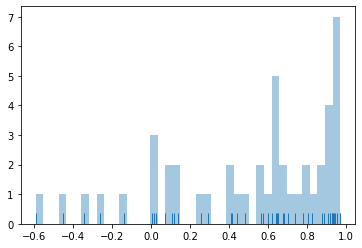

In [ ]:
ratios= []
diffs = []
for entry in data:
    ratio = 1 - entry["transferSizes"][ADAPTED] / entry["transferSizes"][NORMAL]
    if ratio < 0:
        print(entry["name"] + " : " + str(ratio))
    ratios.append(ratio)
    diffs.append(energyConsumption(entry["transferSizes"][NORMAL] - entry["transferSizes"][ADAPTED])*1000*3600)
dfRatios = pd.DataFrame(ratios)
dfDiffs  = pd.DataFrame(diffs)
print("\n\nRATIOS :")
print(dfRatios.describe())
print("\nDIFF(J) :")
print(dfDiffs.describe())

sns.distplot(ratios, bins=40, kde=False, rug=True);




Control Group :
               0
count  46.000000
mean    5.181394
std     7.786924
min     0.228108
25%     1.339511
50%     2.598274
75%     5.597031
max    47.157936

Test Group) :
               0
count  46.000000
mean    2.427305
std     3.780085
min     0.127325
25%     0.430155
50%     0.783176
75%     2.062100
max    17.004808


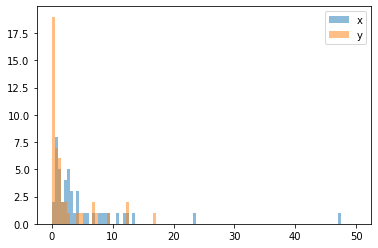

In [ ]:
control= []
test = []
for entry in data:
    control.append(energyConsumption(entry["transferSizes"][NORMAL])*1000)
    test.append(energyConsumption(entry["transferSizes"][ADAPTED])*1000+0.1)
dfControl = pd.DataFrame(control)
dfTest  = pd.DataFrame(test)
print("\n\nControl Group :")
print(dfControl.describe())
print("\nTest Group) :")
print(dfTest.describe())


bins = np.linspace(0, 50, 100)

plt.hist(control, bins, alpha=0.5, label='x')
plt.hist(test, bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

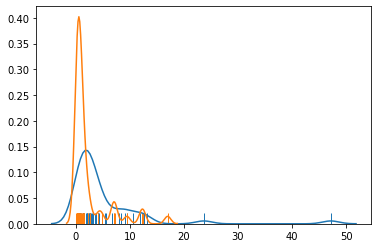

In [ ]:
sns.distplot(control, hist=False, bins=20, rug=True);
sns.distplot(test, hist=False, bins=20, rug=True);

In [ ]:
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

In [ ]:
print("Effect size : " + str(cohend(control, test)))
stats.ttest_ind(a=control,b=test,equal_var=False)

Effect size : 0.44996520938828094


Ttest_indResult(statistic=2.157957335578326, pvalue=0.03462585460561946)